# GluonTS

In [1]:
# IMPORTS
import pandas as pd
import numpy as np
import session_info

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from gluonts.dataset.common import ListDataset
from gluonts.mx.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

C:\Users\Italo\AppData\Roaming\Python\Python37\site-packages\gluonts\json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  "Using `json`-module for json-handling. "


In [2]:
# Leitura dos Dados

df_bf = pd.read_excel('Botafogo-2015-2023_Semanal_Dengue.xlsx')
df_cd = pd.read_excel('CidadeDeDeus-2015-2023_Semanal_Dengue.xlsx')
df_cp = pd.read_excel('Copacabana-2015-2023_Semanal_Dengue.xlsx')
df_ed = pd.read_excel('EngenhoDeDentro-2015-2023_Semanal_Dengue.xlsx')
df_ip = pd.read_excel('Ipanema-2015-2023_Semanal_Dengue.xlsx')
df_lj = pd.read_excel('Laranjeiras-2015-2023_Semanal_Dengue.xlsx')
df_mc = pd.read_excel('Maracana-2015-2023_Semanal_Dengue.xlsx')
df_rc = pd.read_excel('Rocinha-2015-2023_Semanal_Dengue.xlsx')
df_vm = pd.read_excel('VilaMilitar-2015-2023_Semanal_Dengue.xlsx')
df_rl = pd.read_excel('Realengo-2015-2023_Semanal_Dengue.xlsx')

In [3]:
dataframes = [df_bf, df_cd, df_cp, df_ed, df_ip, df_lj, df_mc, df_rc, df_vm, df_rl]
data = pd.concat(dataframes, ignore_index=False)

In [4]:
# Definir um MultiIndex com a 'data' e 'bairro'
data.set_index(['data', 'bairro'], inplace=True)

In [5]:
# Substituir infinitos por NaN
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Checar e preencher valores NaN
if data.isnull().any().any():
    data.fillna(method='ffill', inplace=True)  # Preencher com o último valor válido

In [6]:
exg = ['chuva', 'temperaturaMedia', 'temperaturaMaxima','temperaturaMinima', 'direcaoVento', 'velocidadeVento', 'pressaoAtmosferica', 'semana']

In [7]:
# Escalonamento dos dados (normalização)
scaler = StandardScaler()

data[exg] = scaler.fit_transform(data[exg].values)

In [8]:
prediction_length = 104

In [9]:
# Ajustar o índice de início e fim para o conjunto de treino e teste corretamente
train_end_index = pd.Timestamp('2021-12-31')  # Fim do ano de 2021
test_start_index = pd.Timestamp('2022-01-01')  # Início do ano de 2022

In [10]:
# Filtrar o conjunto de treino (até 31 de dezembro de 2021)
data_train = data.loc[data.index.get_level_values('data') <= train_end_index]

# Filtrar o conjunto de teste (a partir de 1 de janeiro de 2022)
data_test = data.loc[data.index.get_level_values('data') >= test_start_index]

# Obter as datas mínimas e máximas dos conjuntos de treino e teste
train_start_date = data_train.index.get_level_values('data').min()
train_end_date = data_train.index.get_level_values('data').max()

test_start_date = data_test.index.get_level_values('data').min()
test_end_date = data_test.index.get_level_values('data').max()

# Exibir as datas mínimas e máximas para treino e teste
print(f"Train dates : {train_start_date} --- {train_end_date}  (n={len(data_train)})")
print(f"Test dates  : {test_start_date} --- {test_end_date}  (n={len(data_test)})")

Train dates : 2015-01-04 00:00:00 --- 2021-12-26 00:00:00  (n=3650)
Test dates  : 2022-01-02 00:00:00 --- 2023-12-31 00:00:00  (n=1050)


In [11]:
# Criar uma lista de ListDataset para cada bairro
train_datasets = []
test_datasets = []

In [12]:
for bairro in data.index.get_level_values('bairro').unique():
    df_bairro = data.xs(bairro, level='bairro')
    
    train_dataset = ListDataset(
        [{'start': df_bairro.index[0], 'target': df_bairro['dengueChikungunya'][:train_end_index].to_numpy(), 'feat_dynamic_real': df_bairro[exg][:train_end_index].T.to_numpy()}],
        freq='W'
    )
    
    test_dataset = ListDataset(
        [{'start': test_start_index, 'target': df_bairro['dengueChikungunya'][test_start_index:].to_numpy(), 'feat_dynamic_real': df_bairro[exg][test_start_index:].T.to_numpy()}],
        freq='W'
    )
    
    train_datasets.append(train_dataset)
    test_datasets.append(test_dataset)


In [13]:
# Configuração do Estimator
estimator = DeepAREstimator(
    freq='W',
    prediction_length=prediction_length,  # 104 semanas
    trainer=Trainer(epochs=100),
    use_feat_dynamic_real=True,
    cell_type='lstm'
)

In [14]:
# Treinamento e previsão para cada bairro
forecasts_list = []
tss_list = []

In [15]:
for train_dataset, test_dataset in zip(train_datasets, test_datasets):
    predictor = estimator.train(training_data=train_dataset)
    
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_dataset,  # Conjunto de dados de  0teste
        predictor=predictor,  # Modelo treinado
        num_samples=100  # Número de amostras para a geração de previsões
    )
    
    forecasts_list.extend(list(forecast_it))
    tss_list.extend(list(ts_it))  # valores verdadeiros do conjunto de teste

100%|██████████| 50/50 [00:17<00:00,  2.92it/s, epoch=100/100, avg_epoch_loss=3.12]


<Figure size 1000x500 with 0 Axes>

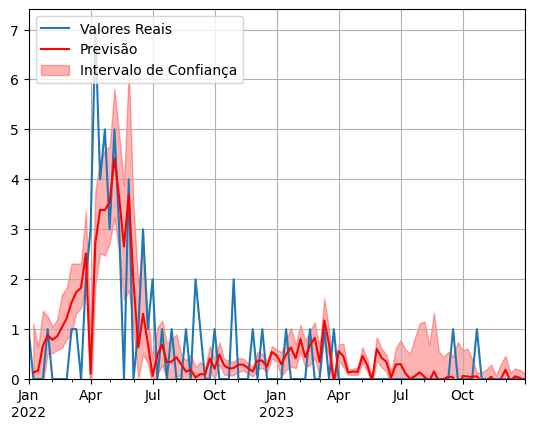

In [16]:
def plot_forecasts(ts_entry, forecast_entry):
    plt.figure(figsize=(10, 5))
    # Plot dos valores observados
    ts_entry.plot(label='_nolegend_')
    
    # Obtenção das previsões e intervalos de confiança
    prediction_mean = forecast_entry.mean_ts

    prediction_mean.plot(label='Previsão', color='r')
    
    plt.fill_between(
        prediction_mean.index,
        forecast_entry.quantile(0.05),
        forecast_entry.quantile(0.95), 
        color='r',
        alpha=0.3,
        label='Intervalo de Confiança 90%'
    )
    
    plt.legend(['Valores Reais', 'Previsão', 'Intervalo de Confiança'], loc='upper left')
    
    plt.ylim(bottom=0)
    plt.grid(True)
    plt.show()

# Plot das previsões para o primeiro bairro
plot_forecasts(tss_list[0], forecasts_list[0])

In [17]:
# Avaliação do modelo usando a mediana das previsões
evaluator = Evaluator(quantiles=[0.5]) 

agg_metrics, item_metrics = evaluator(iter(tss_list), iter(forecasts_list))

# Métrica específica: MSE
mse = agg_metrics["MSE"]
print("Mean Squared Error (MSE):", mse)

Running evaluation: 10it [00:00, 121.92it/s]

Mean Squared Error (MSE): 17.776862063774693



c:\ProgramData\Anaconda3\envs\envNEW\lib\site-packages\pandas\core\dtypes\cast.py:1097: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


In [18]:
def calcular_cobertura_intervalo(tss_list, forecasts_list, lower_q=0.05, upper_q=0.95):
    total = 0
    dentro_intervalo = 0

    for ts, forecast in zip(tss_list, forecasts_list):
        # Sincronizar índices e lidar com NaNs
        true_values = ts.values.flatten()
        
        # Obter limites de confiança
        lower_bound = forecast.quantile(lower_q).flatten()
        upper_bound = forecast.quantile(upper_q).flatten()

        # Garantir que os comprimentos sejam iguais, removendo NaNs e sincronizando
        min_length = min(len(true_values), len(lower_bound), len(upper_bound))
        true_values = true_values[:min_length]
        lower_bound = lower_bound[:min_length]
        upper_bound = upper_bound[:min_length]

        # Contar valores dentro do intervalo de confiança
        dentro_intervalo += ((true_values >= lower_bound) & (true_values <= upper_bound)).sum()
        total += min_length

    # Calcular cobertura
    cobertura = dentro_intervalo / total if total > 0 else 0
    return cobertura

# Calcular e exibir a cobertura do intervalo de confiança
cobertura = calcular_cobertura_intervalo(tss_list, forecasts_list)
print(f'Cobertura do Intervalo de Confiança 90%: {cobertura:.2%}')


Cobertura do Intervalo de Confiança 90%: 42.69%


## Analise por Bairro - GluonTS

In [19]:
# Lista de bairros, assumindo que a ordem de tss_list e forecasts_list corresponda à ordem dos bairros
bairros = data.index.get_level_values('bairro').unique()

In [20]:
# Dicionários para armazenar MSE e cobertura por bairro
mse_por_bairro = {}
cobertura_por_bairro = {}

In [21]:
# Iterar sobre os bairros, tss_list e forecasts_list simultaneamente
for bairro, ts, forecast in zip(bairros, tss_list, forecasts_list):
    # Calcular MSE para o bairro atual
    true_values = ts.values.flatten()
    predicted_values = forecast.mean.flatten()

    # Sincronizar comprimentos para evitar erros de tamanho
    min_length = min(len(true_values), len(predicted_values))
    true_values = true_values[:min_length]
    predicted_values = predicted_values[:min_length]
    
    # Calcular MSE para o bairro ajustado
    mse = mean_squared_error(true_values, predicted_values)
    mse_por_bairro[bairro] = mse
    
    # Calcular cobertura do intervalo de confiança para o bairro atual
    lower_bound = forecast.quantile(0.05).flatten()
    upper_bound = forecast.quantile(0.95).flatten()
    
    # Sincronizar comprimentos para intervalos de confiança
    min_length = min(len(true_values), len(lower_bound), len(upper_bound))
    true_values = true_values[:min_length]
    lower_bound = lower_bound[:min_length]
    upper_bound = upper_bound[:min_length]
    
    dentro_intervalo = ((true_values >= lower_bound) & (true_values <= upper_bound)).sum()
    cobertura = dentro_intervalo / min_length if min_length > 0 else 0
    
    cobertura_por_bairro[bairro] = cobertura

In [22]:
# Exibir os MSEs e coberturas por bairro
print("MSE por Bairro:")
for bairro, mse in mse_por_bairro.items():
    print(f"{bairro}: MSE = {mse:.4f}")

print("\nCobertura do Intervalo de Confiança 90% por Bairro:")
for bairro, cobertura in cobertura_por_bairro.items():
    print(f"{bairro}: Cobertura = {cobertura:.2%}")

MSE por Bairro:
Botafogo: MSE = 0.8273
Cidade de Deus: MSE = 4.8558
Copacabana: MSE = 29.5769
Engenho de Dentro: MSE = 13.9814
Ipanema: MSE = 1.6442
Laranjeiras: MSE = 3.9808
Maracana: MSE = 1.1923
Rocinha: MSE = 24.8077
Vila Militar: MSE = 1.0385
Realengo: MSE = 96.1777

Cobertura do Intervalo de Confiança 90% por Bairro:
Botafogo: Cobertura = 40.38%
Cidade de Deus: Cobertura = 58.65%
Copacabana: Cobertura = 22.12%
Engenho de Dentro: Cobertura = 52.88%
Ipanema: Cobertura = 60.58%
Laranjeiras: Cobertura = 50.00%
Maracana: Cobertura = 63.46%
Rocinha: Cobertura = 33.65%
Vila Militar: Cobertura = 16.35%
Realengo: Cobertura = 28.85%
